# Практическое ДЗ 1. Удаление фона с помощью SVD

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения &mdash; удаление фона из видео.
Для этого сначала загрузим видео, на котором есть движущиеся объекты и неизменный фон.


**Замечание: далее пользоваться циклами запрещено, если это явно не прописано в задании. Вместо этого используйте функции numpy.**

In [1]:
%pip install -q moviepy==1.0.3
%pip install -q ffmpeg

  Preparing metadata (setup.py) ... done


In [2]:
import moviepy.editor as mpe
video = mpe.VideoFileClip("data/SVD_video_1.mp4")
video.ipython_display(width=300, maxduration=250)

  if event.key is 'enter':



Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Импортируем необходимые библиотеки и представим видео в виде трехмерного массива размеров `(#кадров) x (#пикселей по горизонтали) x (#пикселей по вертикали)`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
video.fps

23.976023976023978

In [5]:
def video_to_array(video):
    duration = int(video.duration)
    nframes = int(video.fps * video.duration)
    size_w, size_h = video.size
    arr = np.zeros([nframes, size_h, size_w])
    for i in range(nframes):
        arr[i, :, :] = video.get_frame(i/nframes * duration)[:, :, 0].astype(float)
    print('image size: {1:} x {2:}, \nnumber of frames: {0:}'.format(nframes, size_w, size_h))
    return arr

image size: 80 x 60, 
number of frames: 2883


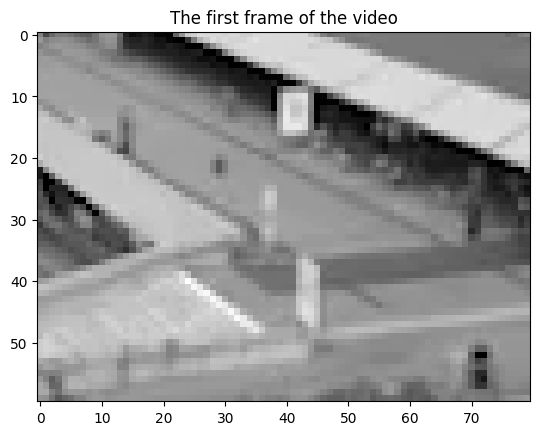

In [6]:
arr = video_to_array(video)
plt.imshow(arr[0, :, :], cmap='gray')
plt.title('The first frame of the video');

### a. Применение базового алгоритма SVD (30 баллов)

1. **(10 балла)** С помощью функции ```np.reshape(...)``` получите из трехмерного массива ```arr``` двумерный массив ```M``` размера ```(size_h * size_w) x nframes```, каждым столбцом которого является изображение размера ```size_h x size_w```, представленное в виде вектора с ```size_h * size_w``` элементами.

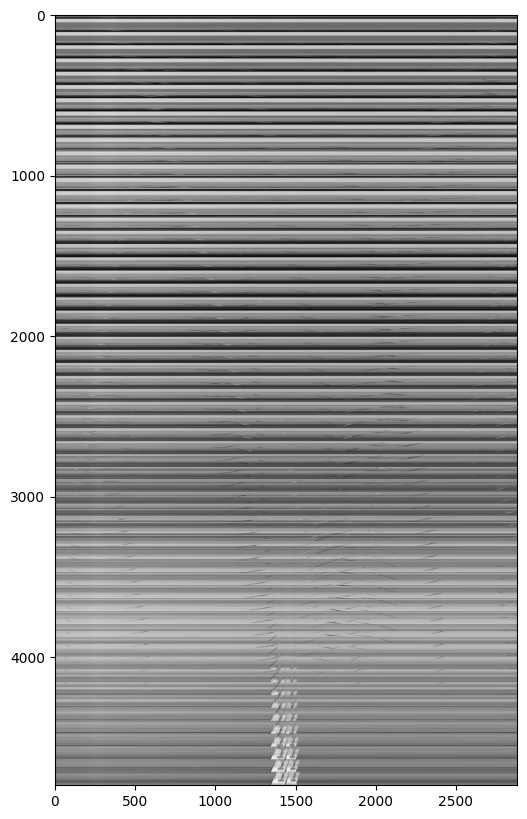

In [7]:
nframes, size_w, size_h = arr.shape
M = np.reshape(arr, (nframes, size_h * size_w)).T

plt.figure(figsize=(10, 10))
plt.imshow(M, cmap='gray');

Если всё сделано правильно, то вы сможете восстановить первый кадр из первого столбца:

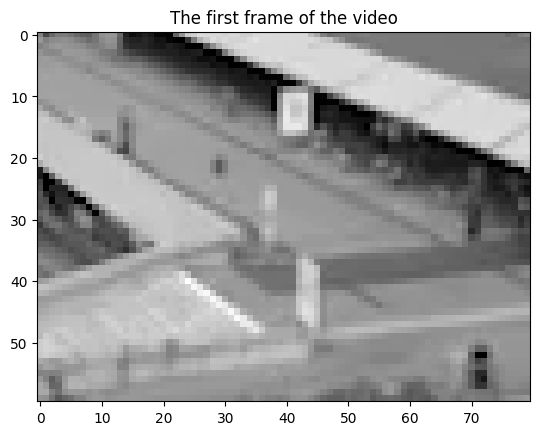

In [8]:
first_frame = M[:,0].reshape(size_w, size_h)
plt.imshow(first_frame, cmap='gray')
plt.title('The first frame of the video');

2. **(6 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd(..., full_matrices=False)``` (параметр ```full_matrices``` отвечает за размеры матрицы $U$ и $V$ из SVD и позволяет заметно экономить место для прямоугольных матриц). Постройте график сингулярных чисел, отсортированных по убыванию и поделенных на старшее сингулярное число. Шкала с сингулярными числами должна быть логарифмической. Для этого, например, используйте функцию ```plt.semilogy```. Объясните, почему наибольшее и несколько наименьших (близких к 0) сингулярных число заметно отличается от остальных.

**Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел. Не забывайте подписывать оси!

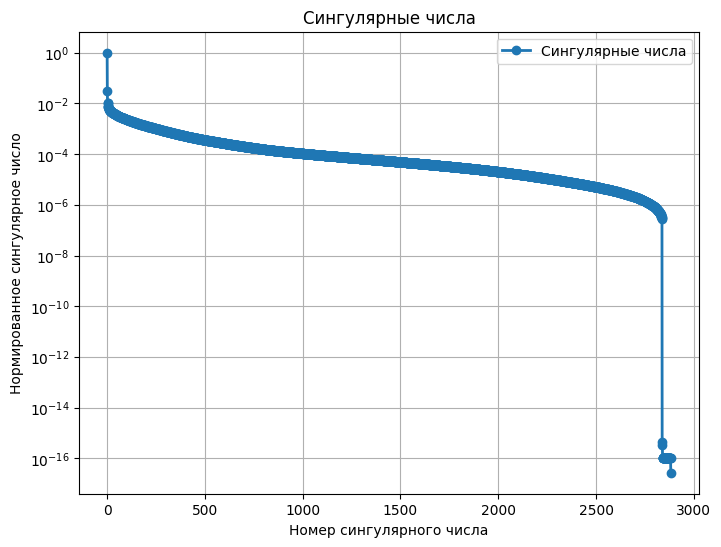

In [51]:
U, S, Vh = np.linalg.svd(M, full_matrices=False)
S_norm = S / S[0]
plt.figure(figsize=(8, 6))
plt.semilogy(S_norm, 'o-', linewidth=2, label='Сингулярные числа')
plt.xlabel('Номер сингулярного числа')
plt.ylabel('Нормированное сингулярное число')
plt.title('Сингулярные числа')
plt.grid(True)
plt.legend()
plt.show()

Разница наибольших, несколькими наименьших сингулярных числел с остальными говорит о том, что в матрице 𝑀 основная часть информации сосредоточена в первых компонентах, а оставшиеся вносят лишь незначительный вклад (или отражают шум).

Почему это так? Начнем с того, что сингулярное разложение ищет направления (сингулярные векторы) в данных, вдоль которых дисперсия максимальна, т.е. где мы получаем больше всего информации. Следовательно, наибольшее сингулярное число соответствует направлению, по которому данные варьируются наибольшим образом. Другими словами, если рассматривать матрицу как набор наблюдений, то существует определённая комбинация признаков (направление в пространстве), в которой разброс данных максимален - это говорит о том, что большинство информации сосредоточено в этом главном направлении (в нашем случае это так, потому что пиксели сильно коррелируют между собой). Маленькие же сингулярные числа (близкие к 0) отражают очень незначительные вариации -  вдоль этих направлений данных практически нет — они либо избыточны, либо содержат шум, который не вносит существенного вклада в общую дисперсию данных.


3. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая считает оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга, а также **относительную** точность этого приближения в фробениусовой норме, т.е. $$
\frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для расчета относительной точности используйте **только** сингулярные числа матрицы $M$.

In [10]:
def trunc_svd(M, r):
    U, S, Vt = np.linalg.svd(M, full_matrices=False)
    M_r = (U[:, :r] * S[:r]) @ Vt[:r, :]
    rel_eps = np.sqrt(np.sum(S[r:]**2)) / np.sqrt(np.sum(S**2))
    return M_r, rel_eps

4. **(4 балла)** Используя написанную функцию, найдите наилучшее приближение матрицы ```M``` матрицей ```M_svd``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [11]:
M_svd, rel_eps = trunc_svd(M, 1)
first_frame = M[:, 0].reshape(size_w, size_h)
background_frame = M_svd[:, 0].reshape(size_w, size_h)
people_frame = first_frame - background_frame

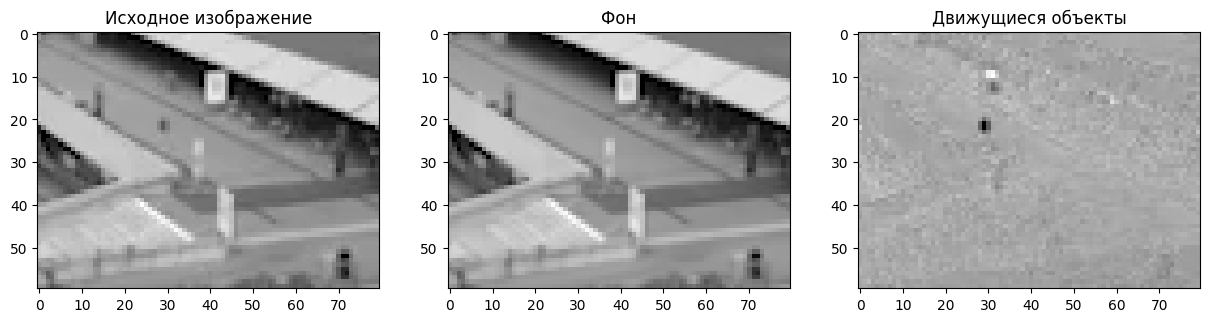

In [12]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(background_frame, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(people_frame, cmap='gray')
axs[2].set_title("Движущиеся объекты");

### b. Применение рандомизированного алгоритма SVD (28 баллов)

Загрузим теперь видео в более высоком разрешении.

In [13]:
import moviepy.editor as mpe
video3 = mpe.VideoFileClip("data/SVD_video_3.mp4", target_resolution=(100, 178))
video3.ipython_display(width=300, maxduration=250)
arr = video_to_array(video3)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
image size: 178 x 100, 
number of frames: 3600


In [14]:
arr3 = video_to_array(video3)
nframes, size_w, size_h = arr3.shape
M3 = np.reshape(arr, (nframes, size_h * size_w)).T

image size: 178 x 100, 
number of frames: 3600


Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений (есть также [пост](https://gregorygundersen.com/blog/2019/01/17/randomized-svd/) с описанием алгоритма).

1. **(16 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + oversampling``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы не вычисляете в явном виде матрицу $QQ^\top$. Если на заданной матрице алгоритм работает слишком долго (минуты), то возможно, вы что-то делаете не так.

In [49]:
def rand_svd(M, r, oversampling=10):
    n = M.shape[1]
    Omega = np.random.randn(n, r + oversampling)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    U, S, Vt = np.linalg.svd(Q.T @ M, full_matrices=False)
    U_approx = Q @ U
    M_r = U_approx[:, :r] @ np.diag(S[:r]) @ Vt[:r, :]
    rel_eps = np.linalg.norm(M_r - M, 'fro') / np.linalg.norm(M, 'fro')
    return M_r, rel_eps

2. **(2 балл)** Используя ```rand_svd```, найдите наилучшее приближение матрицы ```M``` матрицей ```M_rand``` ранга 1. С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео
    - фона (полученного из приближения ранга 1)
    - изображения людей (полученного с помощью изображений из предыдущих двух подпунктов)

In [16]:
M3_r, rel_eps = rand_svd(M3, 1)
first_frame = M3[:, 0].reshape(size_w, size_h)
background_frame = M3_r[:, 0].reshape(size_w, size_h)
people_frame = first_frame - background_frame

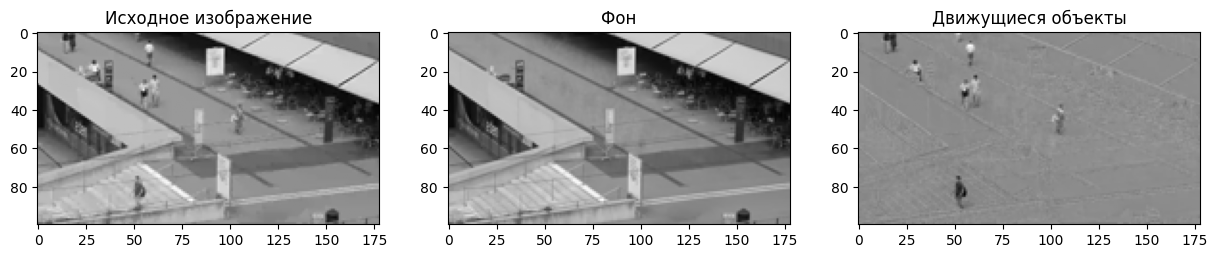

In [17]:
_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(first_frame, cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(background_frame, cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(people_frame, cmap='gray')
axs[2].set_title("Движущиеся объекты");

3. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M||_F}
$$
при $r=2$ в зависимости от $p$ (```oversampling=p``` в функции ```rand_svd```). По $p$ выберите сетку $[0, 30]$ с шагом 2.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу по оси с ошибкой.
**В данном задании разрешается использовать циклы для перебора по сетке и запуска алгоритма 10 раз.**

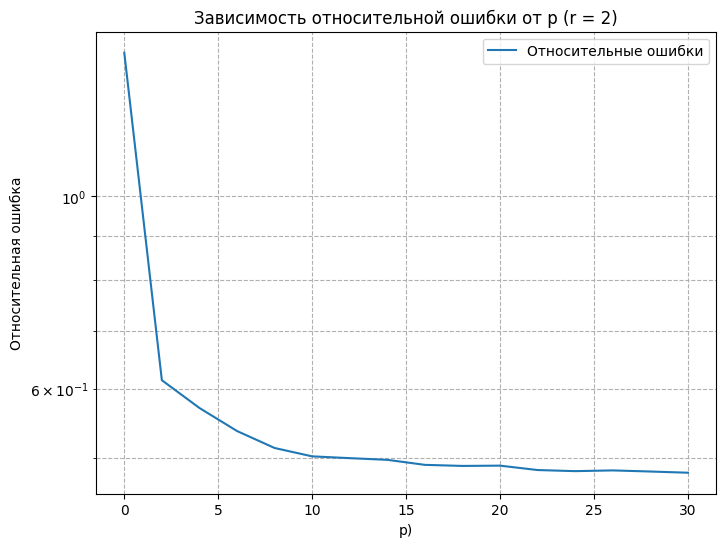

In [19]:
errors = []

for p in np.arange(0, 32, 2):
    error_sum = 0
    for _ in range(10):
        M_r, error = rand_svd(M, r=2, oversampling=p)
        error_sum += error
    errors.append(np.mean(error_sum))

plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, 32, 2), errors, '-', label='Относительные ошибки')
plt.yscale('log')
plt.xlabel('p)')
plt.ylabel('Относительная ошибка')
plt.title('Зависимость относительной ошибки от p (r = 2)')
plt.grid(True, which="both", ls="--")
plt.legend()
plt.show()

**Замечание:** ```np.linalg.svd``` на этих размерах матриц и значенях рангов будет работать заметно медленнее (правда, с полностью контролируемой точностью), чем рандомизированный алгоритм. Также обратите внимание, что если не указать опцию ```full_matrices=False``` в ```np.linalg.svd```, то на данном примере может случиться переполнение по памяти.

### c. Видео с переменным освещением (12 баллов)

Загрузим теперь более интересное видео, в котором со временем меняется освещение (можно, к примеру, представить, что встаёт солнце).

In [20]:
video2 = mpe.VideoFileClip("data/SVD_video_2.mp4")
video2.ipython_display(width=300, maxduration=250)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [21]:
arr2 = video_to_array(video2)

image size: 80 x 60, 
number of frames: 2883


Пока что возьмём лишь первые 80% видео, остальной частью воспользуемся позже.

In [22]:
breakpoint = round(0.8*arr2.shape[0])
remaining = arr2[breakpoint:]
arr2 = arr2[:breakpoint]

1. Аналогично пункту a.1) получите из трехмерного массива ```arr2``` двумерный массив ```M2``` размера ```(size_h * size_w) x nframes2```.

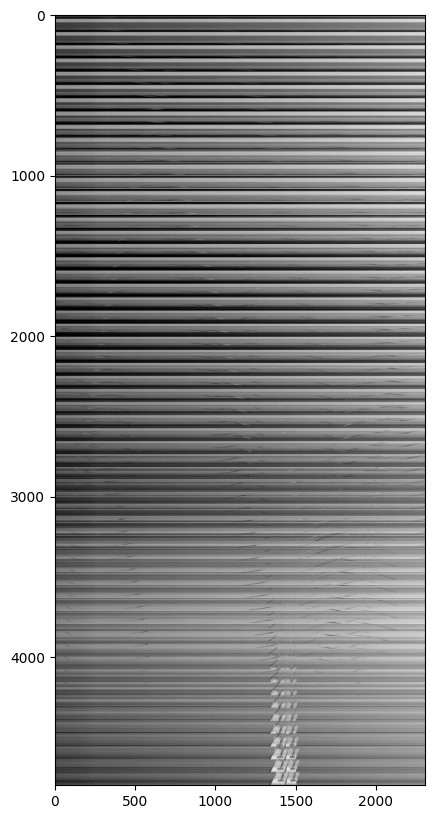

In [23]:
nframes2, size_w, size_h = arr2.shape
M2 = np.reshape(arr2, (nframes2, size_h * size_w)).T

plt.figure(figsize=(10, 10))
plt.imshow(M2, cmap='gray');

2. **(3 балла)** Примените методы из пунктов a) и b) (то есть библиотечное полное SVD и рандомизированное SVD) для получения наилучшего приближения ранга 2 (чтобы также учесть изменение освещения) для матрицы `M2`. Сравните время работы алгоритмов.

In [24]:
%timeit trunc_svd(M2, 2)

15.4 s ± 334 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
%timeit rand_svd(M2, 2)

310 ms ± 20.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [26]:
M2_svd, rel_eps1 = trunc_svd(M2, 2)
M2_rand, rel_eps2 = rand_svd(M2, 2)

3. **(4 балла)** Cравните относительные точности таких приближений для настоящего SVD и рандомизированного алгоритма; также сравните их с соответствующей величиной для видео с постоянным освещением. Какие выводы можно сделать?

In [27]:
M_svd, rel_eps_M = trunc_svd(M3, 2)
M3_svd, rel_eps_M3 = rand_svd(M3, 2)

In [28]:
print(f'Относительная ошибка (точность) для видео с переменным освещением для настоящего SVD (ранг - 2) - {rel_eps1}')
print(f'Относительная ошибка (точность) для видео с переменным освещением для рандомизированного алгоритма (ранг - 2) - {rel_eps2}')
print(f'Относительная ошибка (точность) для видео с постоянным освещением для настоящего SVD (ранг - 2) - {rel_eps_M}')
print(f'Относительная ошибка (точность) для видео с постоянным освещением для рандомизированного алгоритма (ранг - 2) - {rel_eps_M3}')

Относительная ошибка (точность) для видео с переменным освещением для настоящего SVD (ранг - 2) - 0.06063233098450479
Относительная ошибка (точность) для видео с переменным освещением для рандомизированного алгоритма (ранг - 2) - 0.06634107856343033
Относительная ошибка (точность) для видео с постоянным освещением для настоящего SVD (ранг - 2) - 0.04555364920579858
Относительная ошибка (точность) для видео с постоянным освещением для рандомизированного алгоритма (ранг - 2) - 0.04828030764652998


Как мы видим, рандомизированный алгоритм работает во много раз быстрее (из-за меньшего объема вычислений), но имеет чуть большую относительную ошибку.

Разберемся, почему это так.

Изменения освещения добавляют вариативность в данные, которая распределяется по дополнительным сингулярным компонентам. При приближении матрицы рангом 2 часть этой дополнительной информации не учитывается, кроме того, рандомизированный метод, который приближает матрицу через случайное проецирование, может чуть менее точно уловить эти дополнительные вариации, - оба этих фактора приводят к немного большей ошибке.

В видео с постоянным освещением данные более однородны, и большая часть информации сосредоточена в нескольких главных компонентах, следовательно, при приближении ранга 2 почти все существенные особенности сохраняются, поэтому относительная ошибка ниже, чем при переменном. (небольшая потеря точности в рандомизированном SVD, связанная с приближением подпространства, которое при достаточном oversampling'e оказывается близкой к оптимальному решению, но всё же может давать немного большую ошибку по сравнению с полным SVD)

4. **(5 балла)** Заполните пропуски в функции `M_to_video`, преобразующей матрицу типа ```M2``` обратно в видео.

In [29]:
def M_to_video(M, fps, size_w, size_h):
    nframes = M.shape[1]
    arr = M.T.reshape(nframes, size_w, size_h)
    def make_frame(t):
        index = int(t * fps)
        frame = arr[index, :, :]
        frame = np.clip(frame, 0, 255)
        frame_rgb = frame[:, :, np.newaxis][:, :, [0,0,0]]
        return frame_rgb
    return mpe.VideoClip(make_frame, duration=nframes / fps)

Посмотрим, как выглядит предлагаемое приближение.

In [30]:
video2_svd = M_to_video(M2_svd - M2, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Для большей наглядности можете также запустить видео из пункта b) с более высоким разрешением.

### d. Обработка новых кадров (25 баллов)

Предположим, что на камеру поступил новый поток кадров. Мы могли бы увеличить нашу матрицу M2 и пересчитать SVD, но это слишком вычислительно сложно ради нескольких новых кадров. Более того, логично предположить, что если у нас уже было достаточно много кадров в матрице M2, то сингулярные векторы не изменятся сильно от добавления новых кадров.

При этом просто вычесть фон не получится, ведь мы хотим также учитывать изменение освещения. Для этого посчитаем ортогональную проекцию нового кадра на образ матрицы M2.




1. **(15 баллов)** Используя SVD разложение ортогонально спроецируйте новый кадр на образ матрицы M2.

Ваш код должен работать как для 1 кадра (вектора длины size_h * size_w), так и для нескольких (матрицы размера (size_h * size_w) x k). Сложность итогового алгоритма для обработки 1 кадра должна быть O(size_h * size_w). SVD матрицы M2 считайте предпосчитанным.

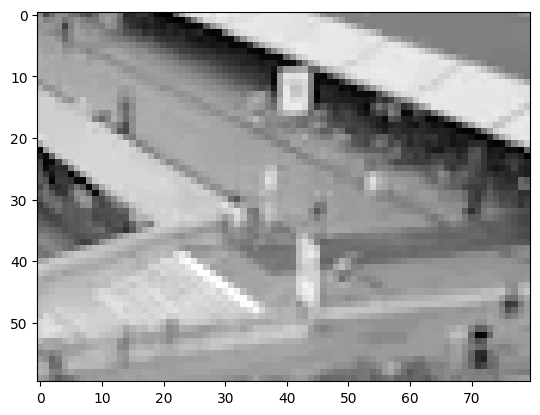

In [31]:
new_frame = remaining[-1].reshape(size_w*size_h)
plt.imshow(new_frame.reshape(size_w, size_h), cmap='gray');

In [32]:
r = 2 #нужный нам ранг

U_2 = np.linalg.svd(M2, full_matrices=False)[0][:, :r]
S_2 = np.linalg.svd(M2, full_matrices=False)[1][:r]
VT_2 = np.linalg.svd(M2, full_matrices=False)[2][:r, :]

In [33]:
def project_new_frames(U, S, VT, new_frames):
    return U @ (U.T @ new_frames)

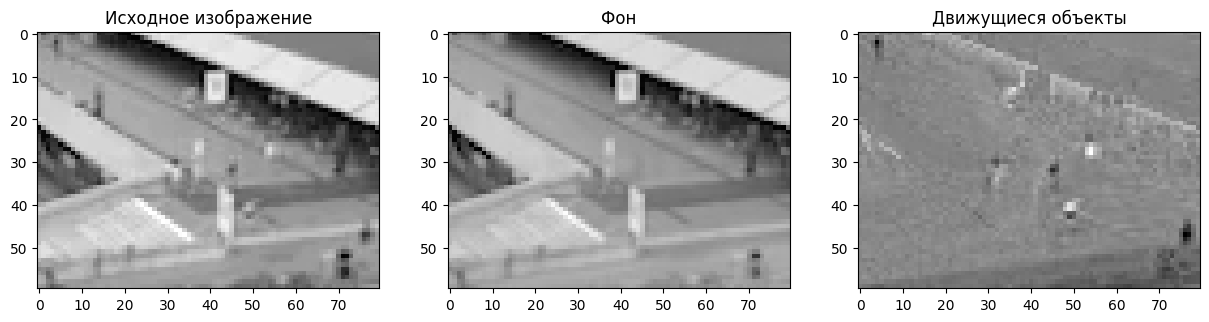

In [34]:
new_frame_proj = project_new_frames(U_2, S_2, VT_2, new_frame)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(new_frame.reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(new_frame_proj.reshape(size_w, size_h), cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow((new_frame - new_frame_proj).reshape(size_w, size_h), cmap='gray')
axs[2].set_title("Движущиеся объекты");

2. **(5 баллов)** Используя [np.concatenate](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html) добавьте кадры из remaining к столбцам M2, чтобы получить матрицу полного видео M_full. Аналогично преобразуйте трехмерный массив remaining в матрицу формате (size_h * size_w x remaining_nframes). Спроецируйте все кадры (столбцы) этой матрицы и преобразуйте матрицу обратно в видео.


In [35]:
remaining_nframes, size_w, size_h = remaining.shape
M_remaining = np.reshape(remaining, (remaining_nframes, size_h * size_w)).T
M_full = np.concatenate((M2, M_remaining), axis=1)

In [36]:
M_proj = project_new_frames(U_2, S_2, VT_2, M_full)

video2_svd = M_to_video(M_full - M_proj, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


3. **(2 балла)** Как говорилось выше, можно сэкономить много ресурсов с помощью рандомизированного SVD алгоритма. Рассмотрите аналогичную ортопроекцию с помощью рандомизированного SVD разложения.

In [37]:
def rand_svd(M, r, oversampling=10):
    n = M.shape[1]
    Omega = np.random.randn(n, r + oversampling)
    Y = M @ Omega
    Q, R = np.linalg.qr(Y)
    U, S, Vt = np.linalg.svd(Q.T @ M, full_matrices=False)
    U_approx = Q @ U
    return U_approx[:, :r], S[:r], Vt[:r, :]

In [38]:
r = 2
oversampling = 10

U_2_rand = rand_svd(M2, 2, oversampling=10)[0]
S_2_rand = rand_svd(M2, 2, oversampling=10)[1]
VT_2_rand = rand_svd(M2, 2, oversampling=10)[2]

In [39]:
M_proj_rand = project_new_frames(U_2_rand, S_2_rand, VT_2_rand, M_full)

video2_svd = M_to_video(M_full - M_proj_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


4. **(3 балла)** Найдите $M_{\text{true}}$ - лучшее приближение 2 ранга матрицы M2_full с помощью честного SVD (аналогично заданию c). Посчитайте относительные точности приближений из пунктов 2 и 3; сравните качество видео. Какие выводы можно сделать по качеству видео и итоговым ошибкам?

$$
    \dfrac{\| M_{\text{true}} - M_{\text{proj}} \|_F}{\| M_{\text{true}} \|_{F}};\quad
    \dfrac{\| M_{\text{true}} - M_{\text{proj rand}} \|_F}{\| M_{\text{true}} \|_{F}}
$$

In [40]:
M_true = trunc_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_true, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [41]:
rel_error_proj = np.linalg.norm(M_true - M_proj, ord='fro') / np.linalg.norm(M_true, ord='fro')
rel_error_proj_rand = np.linalg.norm(M_true - M_proj_rand, ord='fro') / np.linalg.norm(M_true, ord='fro')

In [42]:
print(f'Относительная ошибка (точность) для приближения через SVD - {rel_error_proj}')
print(f'Относительная ошибка (точность) для рандомизированного приближения - {rel_error_proj_rand}')

Относительная ошибка (точность) для приближения через SVD - 0.020001445065678084
Относительная ошибка (точность) для рандомизированного приближения - 0.03073209709173418


In [50]:
M_rand = rand_svd(M_full, 2)[0]

video2_svd = M_to_video(M_full - M_rand, 20, size_w, size_h)
video2_svd.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


**Выводы:**

Из-за случайности в выборе подпространства и ограниченного числа дополнительных векторов (oversampling) рандомизированный SVD может чуть хуже воспроизводить оптимальное подпространство, что приводит к немного большей относительной ошибке.

Качество видео же практически не изменилось (лишь движущиеся объекты из rand_svd переодически тускнеют, в то время как из trunc_svd яркость движущегося объекта постоянная), что и говорит о совсем малой разнице в относительных ошибках.

Таким образом, разница в ошибках отражает компромисс между вычислительной эффективностью и точностью: полный SVD точнее, а рандомизированный алгоритм быстрее, но при этом может допускать незначительное увеличение ошибки.

### e. Robust PCA (5 баллов)

Заметим, что матрицу $M$ можно приближенно представить в виде $M = L + S$, где $L$ - малоранговая матрица, а $S$ - разреженная (то есть содержащая большое количество нулей). Для поиска $L$ и $S$ мы могли бы попытаться решить задачу

$$
    \mathrm{rank}(L) + \alpha\ \mathrm{nnz}(S) \to \min_{L,S}, \quad \alpha > 0
$$

при ограничении $M = L + S$, где $\mathrm{nnz}(S)$ обозначет число ненулевых элементов (<b>n</b>umber of <b>n</b>on<b>z</b>eros).
Однако такую задачу решать крайне сложно из-за отсутствия непрерывности и выпуклости.
Поэтому обычно ее [заменяют на более простую](https://arxiv.org/pdf/0912.3599.pdf):

$$
    \|L\|_* + \alpha \|S\|_{\mathrm{sum}} \to \min_{L, S}, \quad \alpha > 0,
$$

где $\|\cdot\|_*$ обозначает ядерную норму матрицы, а $\|\cdot\|_{\mathrm{sum}}$ является суммой модулей всех элементов матрицы ($\ell_1$-норма).

Для вычисления robust PCA скачаем код по ссылке [https://github.com/dganguli/robust-pca](https://github.com/dganguli/robust-pca) и импортируем его:

In [44]:
# Если вы работаете на windows - скачивайте самостоятельно
!wget https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
import r_pca

--2025-02-26 14:29:48--  https://raw.githubusercontent.com/dganguli/robust-pca/master/r_pca.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3105 (3.0K) [text/plain]
Saving to: ‘r_pca.py’

r_pca.py            100%[===================>]   3.03K  --.-KB/s    in 0s      

2025-02-26 14:29:49 (42.9 MB/s) - ‘r_pca.py’ saved [3105/3105]



Мы использовали класс ```R_pca``` и запустили функцию ```fit(max_iter=4000, iter_print=100)``` для нахождения матриц $L$ и $S$ по матрице $M$ из пункта a).

1. **(5 баллов)** С помощью ```plt.imshow(..., cmap='gray')``` постройте изображения первого кадра
    - исходного видео,
    - фона,
    - изображения людей.

Обратите внимание, что на исходных данных метод может работать довольно долго (вероятно, часы). Поэтому предлагается взять только четверть временного ряда, а также вырезать каждый второй кадр. Используйте видео с низким разрешением из пункта a).

iteration: 1, error: 10.068199117424792
iteration: 100, error: 0.7004423976779164
iteration: 200, error: 0.42632079958320696
iteration: 300, error: 0.28615543342340466
iteration: 400, error: 0.19763762992272108
iteration: 500, error: 0.1491945130599695
iteration: 600, error: 0.1197776098481122
iteration: 700, error: 0.10258379675908802
iteration: 800, error: 0.08740324618615974
iteration: 900, error: 0.07772202053909959
iteration: 1000, error: 0.06319242183847977
iteration: 1100, error: 0.05727756160922441
iteration: 1200, error: 0.04361963207391365
iteration: 1300, error: 0.04277918295975366
iteration: 1400, error: 0.028313363611467284
iteration: 1500, error: 0.028215592055600716
iteration: 1546, error: 0.01770345281066796


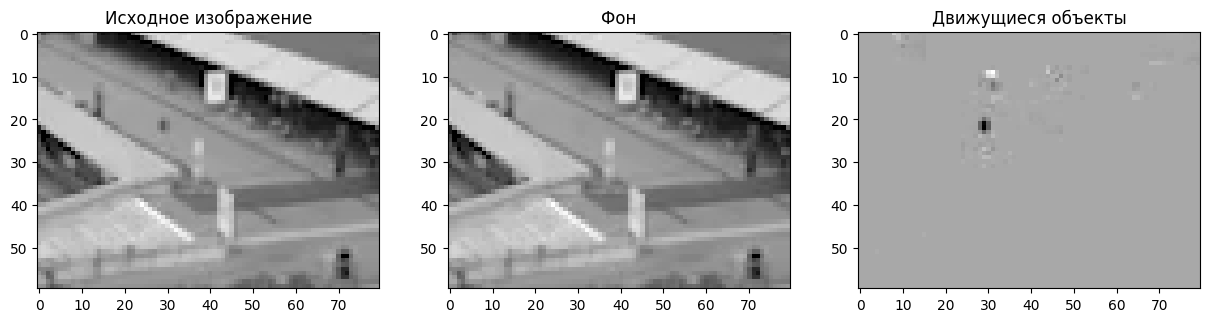

In [45]:
Mt = M[:,:M.shape[1]//4:2]
solver = r_pca.R_pca(Mt, mu=0.68) # в нашем случае такой mu работает лучше исходного
L, S = solver.fit(max_iter=4000, iter_print=100)

_, axs = plt.subplots(1,3, figsize=(15,10))
axs[0].imshow(Mt[:, 0].reshape(size_w, size_h), cmap='gray')
axs[0].set_title("Исходное изображение")
axs[1].imshow(L[:, 0].reshape(size_w, size_h), cmap='gray')
axs[1].set_title("Фон")
axs[2].imshow(S[:, 0].reshape(size_w, size_h), cmap='gray')
axs[2].set_title("Движущиеся объекты");

Аналогично можно посмотреть на видео движущихся объектов:

In [46]:
video_rpca = M_to_video(S, 20, size_w, size_h)
video_rpca.ipython_display(width=300, maxduration=250, fps=20)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### f. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.